Datasets: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In this notebook, I'll do Exploratory Data Analysis (EDA) on the datasets to future machine learning modelling work. This EDA split into four parts:
1. Analyzing Target Variable
2. Dealing with Missing Data
3. Dealing with Outliers
4. Check Normality and Homoscedasticity

In [1]:
# EDA starterpacks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

train_df = pd.read_csv('train.csv')

### 1. Let's analyze our target: 'SalePrice'

In [2]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Skewness:  1.8828757597682129
Kurtosis:  6.536281860064529


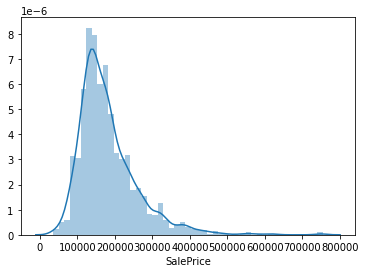

In [3]:
# Distribution plot
sns.distplot(train_df['SalePrice'])

# Skewness and kurtosis
print('Skewness: ', train_df['SalePrice'].skew())
print('Kurtosis: ', train_df['SalePrice'].kurt())

- Positive high skewness.
- High (leptokurtic) kurtosis.
- For clear explanation check this out https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa.

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

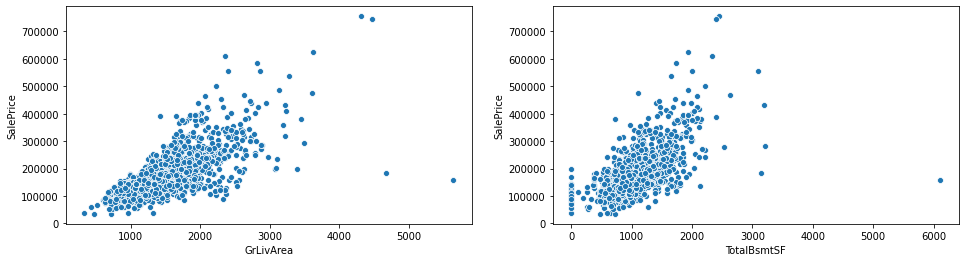

In [4]:
# Scatter plot for expected linear category
# GrLivArea: Above grade (ground) living area square feet
# TotalBsmtSF: Total square feet of basement area

fig, ax = plt.subplots(1,2, figsize=(16,4))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_df, ax=ax[0])
sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=train_df, ax=ax[1])

Both have strong linear relationship with SalePrice and maybe exponential.

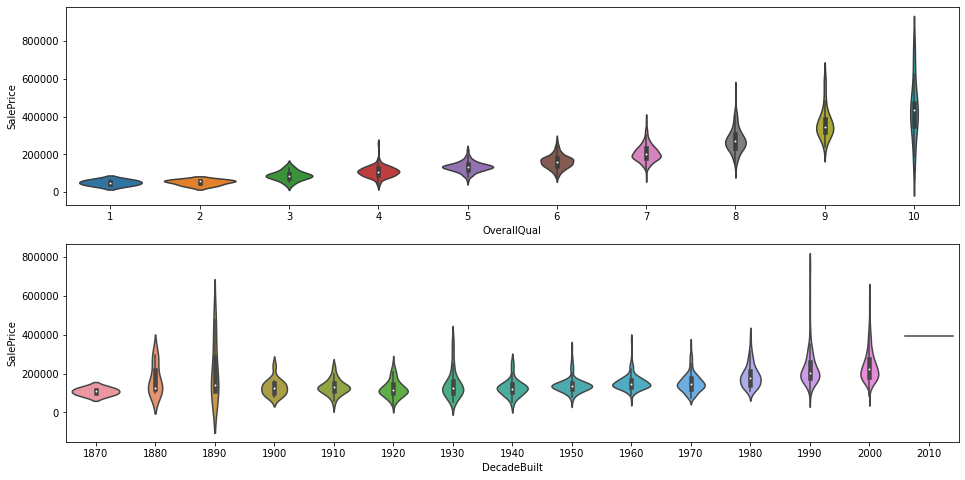

In [5]:
# Without this, the 2nd graph might be too crowded
train_df['DecadeBuilt'] = train_df['YearBuilt'] // 10 * 10

# Scatter plot for expected linear category
# OverallQual: Overall material and finish quality
# YearBuilt: Original construction date (transformed to DecadeBuilt)
fig, ax = plt.subplots(2,1, figsize=(16,8))
sns.violinplot(x='OverallQual', y='SalePrice', data=train_df, ax=ax[0])
sns.violinplot(x='DecadeBuilt', y='SalePrice', data=train_df, ax=ax[1])

train_df.drop(columns='DecadeBuilt', inplace=True)

Both have linear relationship, although it is more strong in 'OverallQual'.

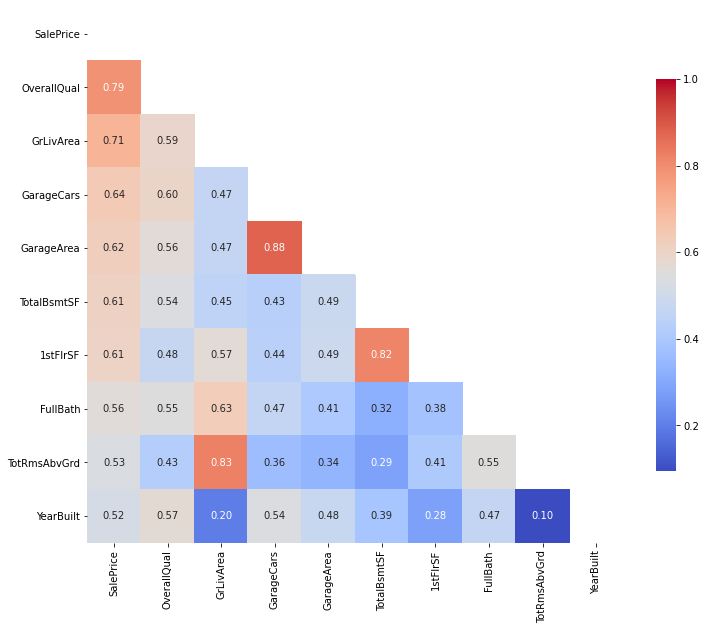

In [6]:
# Heatmap with 10 variables with largest correlation coefficient
k = 10
corrmat = train_df.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)

# To mask upper right triangle
mask = np.zeros(cm.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

plt.figure(figsize=(12,12))
sns.heatmap(cm, cbar=True, cbar_kws={"shrink": .6}, annot=True, square=True, fmt='.2f', cmap='coolwarm', mask=mask,
            annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

- Variable that we've analyzed before ('OverallQual', 'GrLivArea', 'TotalBsmtSF') are strongly correlated with 'SalePrice'.
- 'GarageArea' and 'GarageCars' are strongly correlated, and it's obvious, so we just need one of those for our analysis.
- Same for 'TotRmsAbvGrd' and 'GrLivArea', they are obviously correlated.
- Also for '1stFlrSF' and 'TotalBsmtSF'.

### 2. Let's Fix Missing Data 

In [7]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum() / train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


- When more than 15% of the data is missing, we should delete the corresponding variable and not try to fill the missing data. Also, they might no be important aspects for buying a house.
- For variables with 'Garage...' they have same missing values and we'll delete them since they only account for 5%. Same applies to variables with 'Bsmt...'.
- We've already seen that 'MasVnrArea' and 'MasVnrType' are strongly correlated to 'SalePrice', thus we'll not lose information if we delete them.
- Since 'Electrical' only has one missing value, we'll just drop the observation, not delete the column.

In [8]:
# Dealing with missing data
train_df = train_df.drop((missing_data[missing_data['Total'] > 1]).index, 1)
train_df = train_df.drop(train_df.loc[train_df['Electrical'].isnull()].index)

### 3.Let's Fix Outliers 

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

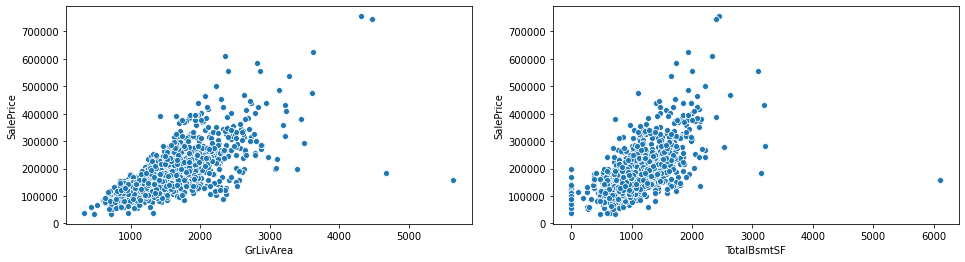

In [9]:
# Scatterplot we've already done
fig, ax = plt.subplots(1,2, figsize=(16,4))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_df, ax=ax[0])
sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=train_df, ax=ax[1])

- 'GrLivArea': The two values in lower right seems strange and not following the trend. This might be a house in agricultural area and not representative for our case, so we'll delete them.
- 'TotalBsmtSF': Also we'll delete values in lower right for the same reason.

In [10]:
# Delete outliers
train_df['GrLivArea'].sort_values(ascending=False)[:2]
train_df = train_df.drop(train_df[train_df['Id'] == 1299].index)
train_df = train_df.drop(train_df[train_df['Id'] == 524].index)

train_df['TotalBsmtSF'].sort_values(ascending=False)[:1]
train_df = train_df.drop(train_df[train_df['Id'] == 333].index)

### 4. Normality and Homoscedasticity 

- We knew that 'SalePrice' distribution plot have high skewness and kurtosis.
- Let's try to fix it by log transform the values.
- Probability plot that closely follow the diagonal normal distribution line is a good indicator for normal distribution.

In [11]:
# Define a function to plot distribution plot and probability plot
from scipy import stats
from scipy.stats import norm

def plot_distproba(column):
    sns.distplot(train_df[column], fit=norm)
    fig = plt.figure()
    res = stats.probplot(train_df[column], plot=plt)

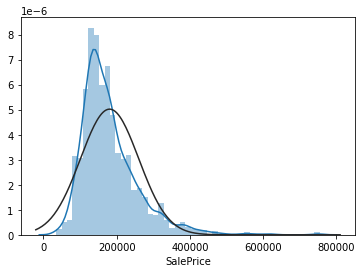

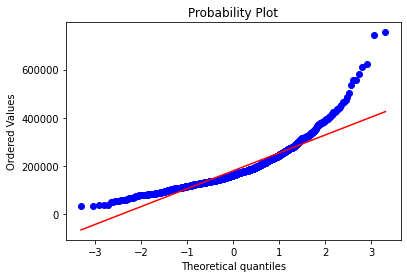

In [12]:
plot_distproba('SalePrice')

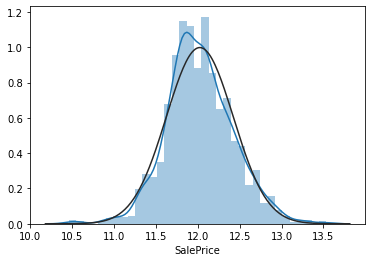

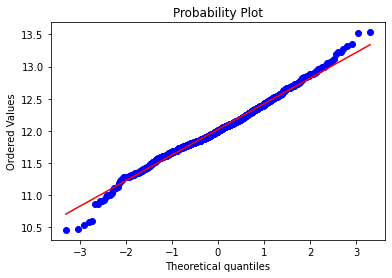

In [13]:
train_df['SalePrice'] = np.log(train_df['SalePrice'])
plot_distproba('SalePrice')

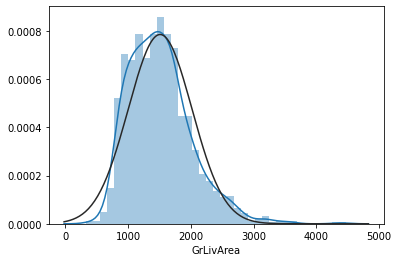

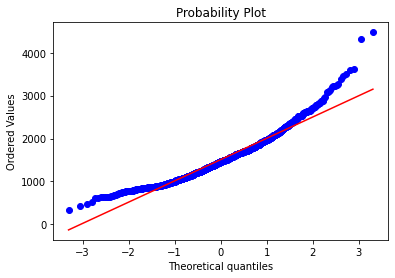

In [14]:
# Let's check on 'GrLivArea'
plot_distproba('GrLivArea')

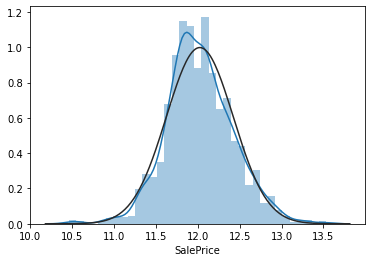

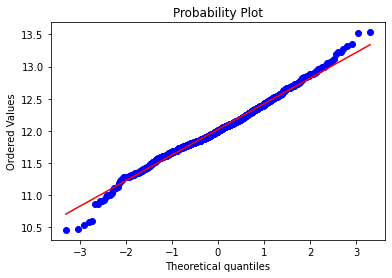

In [15]:
train_df['GrLivArea'] = np.log(train_df['GrLivArea'])
plot_distproba('SalePrice')

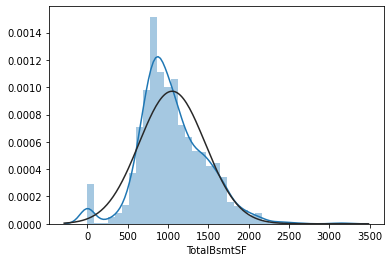

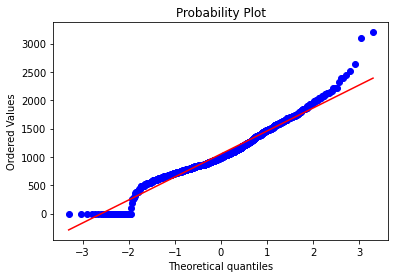

In [16]:
# Let's check on 'TotalBsmtSF'
plot_distproba('TotalBsmtSF')

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

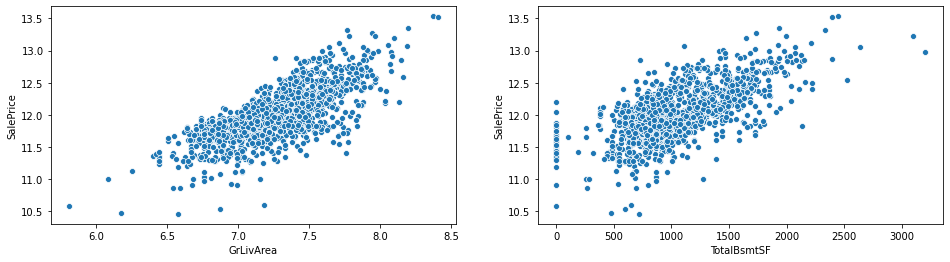

In [17]:
fig, ax = plt.subplots(1,2, figsize=(16,4))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_df, ax=ax[0])
sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=train_df, ax=ax[1])

- Compare the old scatter plot and already log-transformed scatter plot to show the 'homoscedasticity'.
- Other variables can be tranformed like this too!
- Last but not least, we'll convert categorical variables with dummy variables

In [18]:
train_df = pd.get_dummies(train_df)

In [19]:
train_df.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,8450,7,5,2003,2003,706,0,150,856,856,854,0,7.444249,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008,12.247694,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,2,20,9600,6,8,197

### The Data is Ready for Some Machine Learning! 